In [1]:
import pandas as pd
import torch
import numpy as np

# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    preds = preds.to('cpu')
    labels = labels.to('cpu')

    labels[labels > 0.0] = 1.0  # label smoothingする場合もスコア計算のため1にしてしまう
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    # num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [2]:

input_dir = "../oof/"
oof0 = pd.read_csv(input_dir + "fold0_oof.csv")
oof1 = pd.read_csv(input_dir + "fold1_oof.csv")
oof2 = pd.read_csv(input_dir + "fold2_oof.csv")
oof3 = pd.read_csv(input_dir + "fold3_oof.csv")
oof4 = pd.read_csv(input_dir + "fold4_oof.csv")
oof = pd.concat([oof0, oof1, oof2, oof3, oof4])
oof

,patch,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,0,00204008d,0.388839,0.400301,0.444385,0.456869,0.365506,0.443940,0.425184,0.454779,...,0.402602,0.452944,0.405192,0.402140,0.718833,0.442393,0.426652,0.380903,0.385289,0.447050
1,1,00204008d,0.413053,0.426108,0.444106,0.458102,0.359499,0.440746,0.425694,0.460345,...,0.403391,0.469417,0.410445,0.405224,0.703724,0.444906,0.428327,0.392969,0.352724,0.443755
2,2,00204008d,0.400161,0.386512,0.443300,0.426421,0.349051,0.526166,0.425017,0.403028,...,0.409017,0.448204,0.412030,0.410249,0.573275,0.444543,0.436819,0.362264,0.363831,0.437698
3,3,00204008d,0.424451,0.389848,0.444761,0.453182,0.363450,0.441582,0.426289,0.436665,...,0.398530,0.437386,0.399447,0.403197,0.691345,0.439346,0.425039,0.384399,0.345197,0.447465
4,4,00204008d,0.457233,0.328380,0.437612,0.441657,0.337332,0.440208,0.425606,0.431339,...,0.390283,0.446664,0.384524,0.377371,0.790667,0.443833,0.408479,0.375834,0.390951,0.446790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,3,ffc51b999,0.617157,0.458993,0.456473,0.442859,0.408201,0.444333,0.445392,0.462076,...,0.450080,0.418472,0.456853,0.436164,0.437196,0.453537,0.449076,0.455796,0.292711,0.449083
7548,4,ffc51b999,0.379266,0.457495,0.458051,0.444310,0.381666,0.443385,0.441922,0.449407,...,0.464344,0.418222,0.449390,0.439424,0.392345,0.445512,0.447530,0.445514,0.344163,0.444928
7549,5,ffc51b999,0.377728,0.453948,0.455647,0.459933,0.410888,0.445344,0.440310,0.450840,...,0.462218,0.431957,0.519024,0.453018,0.406728,0.447433,0.449198,0.463891,0.334271,0.446323
7550,6,ffc51b999,0.361325,0.488804,0.459886,0.451237,0.384450,0.444176,0.437296,0.451156,...,0.460170,0.421941,0.460414,0.442230,0.391435,0.445119,0.445296,0.445489,0.274580,0.443030


In [3]:
oof2 = oof.groupby('recording_id').max().reset_index(drop=False)
oof2

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,00204008d,7,0.457233,0.426108,0.444761,0.458102,0.365506,0.526166,0.428083,0.460345,...,0.409017,0.469417,0.412030,0.410249,0.790667,0.498771,0.436819,0.407147,0.390951,0.450338
1,003b04435,7,0.528597,0.913295,0.871266,0.812116,0.447694,0.453690,0.452712,0.459338,...,0.431918,0.398926,0.452681,0.428757,0.527496,0.438440,0.460912,0.439353,0.400656,0.442884
2,003bec244,7,0.418618,0.735148,0.432816,0.667090,0.454565,0.556305,0.495131,0.873250,...,0.659684,0.453744,0.426848,0.443046,0.466168,0.444138,0.453781,0.431391,0.424338,0.440792
3,005f1f9a5,7,0.436282,0.725134,0.464517,0.805374,0.438158,0.460427,0.438965,0.849456,...,0.464947,0.464022,0.460563,0.448875,0.479612,0.448239,0.456199,0.457002,0.405939,0.431987
4,006ab765f,7,0.414059,0.445632,0.455483,0.461156,0.449075,0.445785,0.449796,0.461478,...,0.471460,0.430100,0.448259,0.446161,0.459838,0.450800,0.447716,0.454672,0.353570,0.867027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,ffc6031f8,7,0.339320,0.468102,0.436852,0.798675,0.292666,0.397013,0.444576,0.937691,...,0.485841,0.936128,0.458928,0.387619,0.446177,0.424758,0.532810,0.490883,0.388530,0.323595
4723,ffd88cd84,7,0.768539,0.901382,0.435205,0.837973,0.421219,0.447577,0.467724,0.474556,...,0.466148,0.939503,0.451903,0.416294,0.557164,0.430863,0.449168,0.490136,0.421007,0.453502
4724,ffebe7313,7,0.473779,0.464623,0.458501,0.603527,0.815343,0.437975,0.431569,0.482988,...,0.425762,0.487138,0.449123,0.455654,0.428014,0.448897,0.436604,0.965383,0.359498,0.435339
4725,fff163132,7,0.343913,0.432981,0.452336,0.468970,0.478721,0.448528,0.453942,0.445920,...,0.418880,0.421403,0.444948,0.459091,0.472290,0.453982,0.447014,0.421707,0.331133,0.438600


In [4]:
tp = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv")
tp_fnames, tp_labels = [], []
for recording_id, df in tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v >= 1).astype(int).tolist()
    tp_fnames.append(recording_id)
    tp_labels.append(v) 

tp2 = pd.DataFrame(tp_labels, columns=[f's{i}' for i in range(24)])
tp2['recording_id'] = tp_fnames
tp2 = tp2.sort_values('recording_id')
tp2


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,recording_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,003bec244
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,006ab765f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,007f87ba2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0099c367b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,009b760e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fe8d9ac40
1128,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fea6b438a
1129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ff2eb9ce5
1130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ffb8d8391


In [5]:
tp_oof = oof2[oof2['recording_id'].isin(tp2['recording_id'])].reset_index(drop=True).sort_values('recording_id')
tp_oof

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.418618,0.735148,0.432816,0.667090,0.454565,0.556305,0.495131,0.873250,...,0.659684,0.453744,0.426848,0.443046,0.466168,0.444138,0.453781,0.431391,0.424338,0.440792
1,006ab765f,7,0.414059,0.445632,0.455483,0.461156,0.449075,0.445785,0.449796,0.461478,...,0.471460,0.430100,0.448259,0.446161,0.459838,0.450800,0.447716,0.454672,0.353570,0.867027
2,007f87ba2,7,0.350501,0.420439,0.453914,0.822345,0.920088,0.464155,0.422014,0.544940,...,0.496731,0.396599,0.450780,0.434002,0.498889,0.445994,0.453257,0.457481,0.425336,0.442831
3,0099c367b,7,0.416441,0.465030,0.464114,0.458962,0.460161,0.453141,0.499607,0.479363,...,0.503181,0.437360,0.456496,0.592392,0.442135,0.450205,0.455605,0.457559,0.335789,0.447422
4,009b760e6,7,0.477847,0.445070,0.472643,0.519394,0.446506,0.437407,0.449514,0.504886,...,0.498633,0.465485,0.442477,0.451319,0.472352,0.440765,0.453418,0.460165,0.245285,0.564637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,7,0.467281,0.527837,0.416272,0.705771,0.411775,0.465143,0.450655,0.456012,...,0.454628,0.416034,0.509920,0.460885,0.465793,0.469488,0.451428,0.426757,0.536076,0.456464
1128,fea6b438a,7,0.495453,0.444048,0.451176,0.786295,0.960419,0.454819,0.441161,0.474888,...,0.480081,0.501949,0.461826,0.467426,0.491499,0.441521,0.450661,0.917219,0.449100,0.451512
1129,ff2eb9ce5,7,0.958889,0.452369,0.462706,0.781326,0.439493,0.449613,0.444334,0.576342,...,0.458677,0.441662,0.434436,0.426338,0.893999,0.423764,0.434274,0.439977,0.447698,0.445228
1130,ffb8d8391,7,0.510353,0.526462,0.444140,0.826260,0.463072,0.601139,0.443194,0.468116,...,0.476605,0.469559,0.436582,0.437882,0.815835,0.432534,0.447311,0.457342,0.440095,0.449328


In [6]:
tp2 = tp2[tp2["recording_id"].isin(tp_oof["recording_id"])]

In [7]:
pred = tp_oof.loc[:, 's0':'s23'].values
target = tp2.loc[:, 's0':'s23'].values

In [8]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(target, pred, average=None)
auc

array([0.98467652, 0.95602588, 0.99658197, 0.7707024 , 0.97574861,
       0.97451017, 0.99815328, 0.94144177, 0.98247689, 0.98913613,
       0.99513822, 0.96467652, 0.9731793 , 0.99768946, 0.99042514,
       0.97215413, 0.99760822, 0.98977819, 0.94510166, 0.99921754,
       0.99593697, 0.96939002, 0.99392129, 0.99081894])

<BarContainer object of 24 artists>

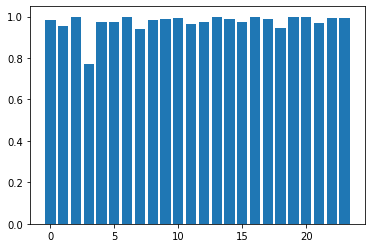

In [9]:
plt.bar(np.arange(24), auc)

In [10]:
pred = torch.tensor(pred)
target = torch.tensor(target)
pred.shape, target.shape

(torch.Size([1132, 24]), torch.Size([1132, 24]))

In [11]:
original_lwlrap = LWLRAP(pred, target)
original_lwlrap

0.8176038265228271